## Unsupervised Hierarchical Clustering of Music Listening Behavior and Mental Health Patterns

### Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

### Loading Dataset

In [2]:
df = pd.read_csv('../data/mxmh_survey_results.csv')
print("Initial shape:", df.shape)

Initial shape: (736, 33)


### Pre-Processing

In [3]:
# Dropping irrelevant or unreliable columns
df = df.drop(columns=['Timestamp', 'Permissions'], errors='ignore')
if 'BPM' in df.columns:
    df = df.drop(columns=['BPM'])

# Converting Age and Hours to numeric and impute missing values
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Hours per day'] = pd.to_numeric(df['Hours per day'], errors='coerce')
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Hours per day'] = df['Hours per day'].fillna(df['Hours per day'].median())

# Storing unscaled versions for later visualization if needed
df['Age_unscaled'] = df['Age']
df['Hours_unscaled'] = df['Hours per day']
df['Fav genre_raw'] = df['Fav genre']

# Handling categorical NA values
cat_cols = ['Primary streaming service', 'While working', 'Instrumentalist',
            'Composer', 'Foreign languages', 'Music effects']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

# Binary mapping (Yes/No → 1/0)
binary_map = {'Yes': 1, 'No': 0}
binary_cols = ['Instrumentalist', 'Composer', 'Exploratory', 'Foreign languages']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map(binary_map)

# Ordinal encoding for genre frequencies
frequency_map = {'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Very Often': 3}
genre_cols = [col for col in df.columns if col.startswith('Frequency')]
for col in genre_cols:
    df[col] = df[col].astype(str).str.strip().str.title().map(frequency_map).fillna(0)

# Dropping mental health target variables (used only for profiling later)
for target in ['Depression', 'Anxiety', 'OCD', 'Insomnia', 'Depression_HighRisk', 'Depression_HighRisk_Label']:
    if target in df.columns:
        df = df.drop(columns=[target])

# Encoding nominal categorical columns
df['While working'] = df['While working'].astype('category').cat.codes
df['Music effects'] = df['Music effects'].astype('category').cat.codes

# One-hot encoding nominal categorical variables
df = pd.get_dummies(df, columns=['Primary streaming service', 'Fav genre'], drop_first=False)

# Selecting and scaling features for clustering
clustering_features = ['Age', 'Hours per day'] + genre_cols
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df[clustering_features]
X_scaled = scaler.fit_transform(X)

# Final check
print("Final shape for clustering input:", X_scaled.shape)

Final shape for clustering input: (736, 18)


### Plotting the Dendrogram to Decide Number of Clusters

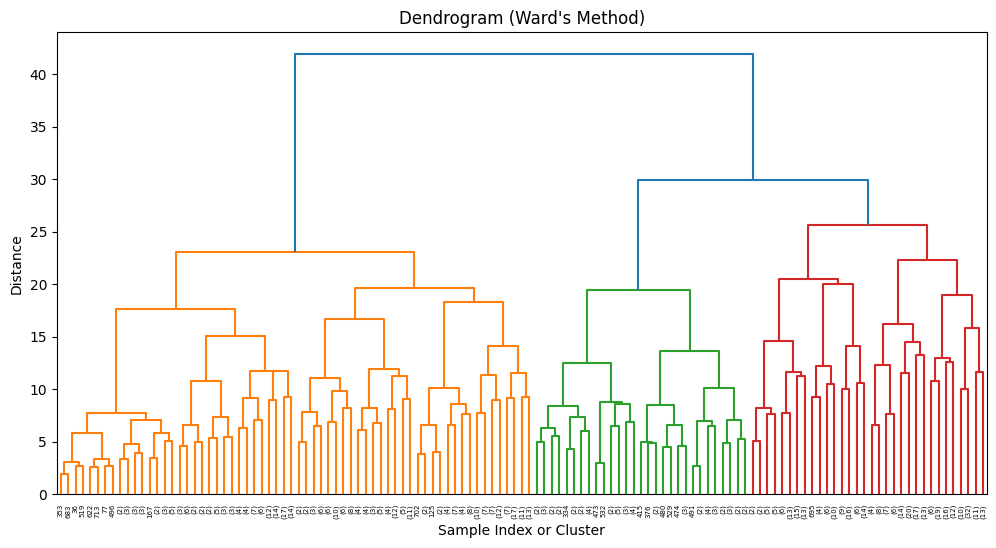

In [4]:
# Creating linkage matrix using Ward's method
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=6)  # truncating to focus on top levels
plt.title("Dendrogram (Ward's Method)")
plt.xlabel("Sample Index or Cluster")
plt.ylabel("Distance")
plt.savefig("../plots/21. Dendrogram(Ward's Method).png")
plt.show()

We can see from the dendrogram that there is an extremely large vertical distance at the top among 3 and 4 large branches showing natural separation within clusters. The greatest rise in linkage distance is when the last 3 clusters are merged into 2, which typically reflects an optimal cutting point.

* Decision between 3 or 4 clusters thus is reasonable.
* The clear-cut structure leads to users differing substantially in their listening pattern for music.
* We will begin with 4 clusters to leave more complexity for profile.
* If quality of cluster is poor, we can backtrack and set to 3.

### Performing Agglomerative Clustering

In [5]:
# Fitting Agglomerative Clustering with 4 clusters
model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
cluster_labels = model.fit_predict(X_scaled)

# Adding cluster labels to the original dataframe
df['Cluster'] = cluster_labels

# Previewing distribution of users in each cluster
cluster_counts = df['Cluster'].value_counts().sort_index()
print("Number of users in each cluster:")
print(cluster_counts)

Number of users in each cluster:
Cluster
0    338
1    208
2     63
3    127
Name: count, dtype: int64


The cluster results yield a moderate skewness of distribution among the four clusters: Cluster 0 (338 users) and Cluster 1 (208 users) are the largest clusters, with the smallest being Cluster 2 with 63 users, and Cluster 3 has 127 users. This suggests that the majority of users share common music listening patterns categoried under Clusters 0 and 1, and that Clusters 2 and 3 are specialized or distinct patterns. The presence of the small clusters may indicate unique listener profiles which may be highly informative when analyzed in combination with measures of mental health.

### Visualizing Clusters Using PCA (2D Projection)

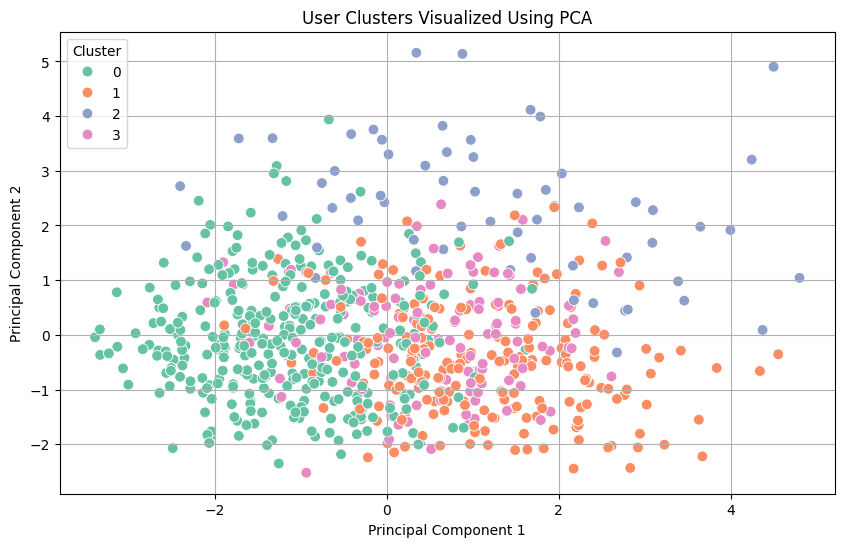

In [6]:
# Reducing to 2 principal components for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Adding PCA components to the DataFrame for plotting
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=60)
plt.title("User Clusters Visualized Using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title='Cluster')
plt.savefig("../plots/22. User_Clusters_Visualized_Using_PCA.png")
plt.show()

The PCA plot illustrates moderate separation of the users into four clusters based on their music listening habits. Blue Cluster 2 is the most separated and shows that it's another category with different behavior compared to the others. Green Cluster 0, orange Cluster 1, and pink Cluster 3 share some similarity but still show different groups. This overlap can be expected since PCA reduces high-dimensional data to just two components. In general, the clustering shows substantial structure worthy of further exploration with mental health profiling.

### Cluster Profiling Using Mental Health Scores

In [7]:
# Attaching cluster labels to original unprocessed dataset for profiling
original_df = pd.read_csv("../data/mxmh_survey_results.csv")
original_df['Cluster'] = df['Cluster']  # Aligning using index

In [8]:
# Defining mental health-related columns to analyze
mental_cols = ['Depression', 'Anxiety', 'OCD', 'Insomnia']

# Ensuring all mental health columns are converted to numeric (to handle any text/missing entries)
for col in mental_cols:
    original_df[col] = pd.to_numeric(original_df[col], errors='coerce')

# Grouping by cluster to compute the average mental health scores, daily music listening, and age
cluster_profile = original_df.groupby('Cluster')[mental_cols + ['Hours per day', 'Age']].mean().round(2)

# Displaying the summary table for interpretation
print("Cluster Mental Health & Behavior Summary:\n")
display(cluster_profile)

Cluster Mental Health & Behavior Summary:



,Depression,Anxiety,OCD,Insomnia,Hours per day,Age
Cluster,,,,,,
0,4.65,5.82,2.60,3.70,3.26,22.99
1,5.27,6.12,2.68,3.49,3.43,22.20
2,3.51,4.43,1.98,3.79,3.00,50.62
3,5.03,6.13,2.98,4.22,4.93,23.40


**Cluster Profiling Summary:**
The hierarchical cluster identified four user groups based on listening behavior and demographics with striking differences in mental health outcomes:

**1. Cluster 0 – Young Listeners in Balance:**
This largest group (338 users) consists of young adults (~23 years) with mean music use and mean mental health scores. They are a control group without extreme emotional or behavioral patterns.

**2. Cluster 1 – Emotionally Vulnerable Youth:**
Having 208 members, the cluster has depression and anxiety levels at high with moderate musical listening. It suggests a cluster of young people who are experiencing emotional stress regardless of musical experience.

**3. Cluster 2 – Emotionally Stable Older Adults:**
With 63 users and a median age of 50, this segment is highest risk for mental health and lowest music participation. Their particular demographic and emotional composition makes them singularly isolated from the active, younger segments.

**4. Cluster 3 – High-Risk Heavy Listeners:**
This cluster (127 users) self-reports highest emotional distress (anxiety, insomnia, OCD) and listens to music most intently (~5 hours/day). It can be reflective of users utilizing music for regulation.

**Conclusion:**
These clusters demonstrate that music behavior and age can naturally divide individuals with similar mental health profiles. This segmentation can be the building block of mental health screening or focussed music therapy interventions.

### Analyze Genre Preferences per Cluster 

In [9]:
# Defining frequency mapping for ordinal encoding of genre listening levels
frequency_map = {'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Very Often': 3}

# Identifying all genre-related columns that begin with 'Frequency'
genre_cols = [col for col in original_df.columns if col.startswith('Frequency')]

# Converting genre frequencies to numeric values using the predefined mapping
for col in genre_cols:
    original_df[col] = original_df[col].astype(str).str.strip().str.title().map(frequency_map).fillna(0)

# Calculating the average listening frequency per genre within each cluster
genre_summary = original_df.groupby('Cluster')[genre_cols].mean().round(2)

# Displaying the summarized genre preferences by cluster
print("Genre Preference by Cluster:\n")
display(genre_summary)

Genre Preference by Cluster:



,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music]
Cluster,,,,,,,,,,,,,,,,
0,0.70,0.42,0.46,0.57,0.08,0.56,0.58,0.22,0.19,0.57,0.57,0.97,0.43,0.43,0.58,0.80
1,1.05,0.70,0.69,0.69,0.67,1.39,1.11,0.53,0.42,1.10,0.68,0.86,1.23,1.38,0.93,0.96
2,1.38,1.06,0.41,1.13,0.59,1.00,1.17,0.56,0.92,0.37,0.78,1.38,1.25,0.95,0.81,0.30
3,0.91,0.79,1.27,0.83,0.29,0.85,0.77,0.70,1.09,0.67,0.61,0.57,0.76,0.87,0.74,0.64


**Summary of Genre Affiliations by Cluster:**
All genre affiliation by cluster matches their emotional and demographic profiles:

* **Cluster 0 – General Listeners with Moderate Preferences:** reflects firm, medium-sized listening genres like Pop, Rock, and Jazz. It matches their mean scores for mental health, with uncommitted music involvement without depending on emotion.

* **Cluster 1 – Emotionally Vulnerable Youth Favoring High-Stimulation Genres:** likes emotionally provocative and high-stimulus music genres of Hip Hop, Rap, R&B, and EDM. These are consistent with their high scores for depression and anxiety, perhaps as a reflection of controlling emotion with music.

* **Cluster 2 – Older Adults with Preference for Calmer Genres:** the oldest and emotionally most stable cluster, likes soothing music genres such as Classical, Jazz, and Folk. This suggests that structured or calming music accompanies emotional stability.

* **Cluster 3 – High-Risk Heavy Listeners Gravitate Toward Stimulating and Escapist Genres:** highest distress, are more frequent users of active styles like EDM, Latin, and K-pop. Predictive preference is for likely use of music for mood management or use for escape.

**Conclusion:** Variance in music preference for both age and lifestyle is not only associated, but variance in preference for music also is linked to underlying patterns of mental health, making utilization of behavioral clustering a path to psychological insight.

### Final Cluster Summary Table

In [10]:
# Selecting a subset of genre columns that best represent a mix of calm, energetic, and emotionally expressive genres
selected_genres = ['Frequency [Classical]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
                   'Frequency [EDM]', 'Frequency [Rap]', 'Frequency [Lofi]']

# Combining mental health scores, behavioral traits, and selected genre preferences by cluster
summary_table = (
    original_df.groupby('Cluster')[mental_cols + ['Hours per day', 'Age'] + selected_genres]
    .mean()
    .round(2)
)

# Displaying the final summary table that encapsulates the key characteristics of each cluster
print("Final Cluster Summary Table:")
display(summary_table)

Final Cluster Summary Table:


,Depression,Anxiety,OCD,Insomnia,Hours per day,Age,Frequency [Classical],Frequency [Hip hop],Frequency [Jazz],Frequency [EDM],Frequency [Rap],Frequency [Lofi]
Cluster,,,,,,,,,,,,
0,4.65,5.82,2.60,3.70,3.26,22.99,0.70,0.56,0.58,0.46,0.43,0.57
1,5.27,6.12,2.68,3.49,3.43,22.20,1.05,1.39,1.11,0.69,1.38,1.10
2,3.51,4.43,1.98,3.79,3.00,50.62,1.38,1.00,1.17,0.41,0.95,0.37
3,5.03,6.13,2.98,4.22,4.93,23.40,0.91,0.85,0.77,1.27,0.87,0.67


The final cluster summary table reflects clear differences across the four groups according to mental health status, listening behavior to music, and their preferred music genres. Cluster 2, consisting of old individuals (mean age 50), reflects the lowest depression, anxiety, OCD, and insomnia scores, with a tendency towards less severe genres like Classical, Jazz, and Folk. Cluster 0, the largest and most moderately distressed cluster of young adults, has a balanced genre preference with no extreme trends for either mental health or music behavior. Cluster 1, although similar in age to Cluster 0, shows highest depression and anxiety levels, and has strong endorsement of emotional genres of Hip Hop, Rap, and R&B — suggesting music as an emotional release. Cluster 3, which listens for the longest amount of time on average (close to 5 hours a day), also scores highest on OCD and insomnia, and prefers high-stimulation or immersive genres like EDM and K-pop. Genre immersion and listening duration both appear highly correlated with emotional distress, validating that music behavior can be a good proxy for segmentation by mental health.

### Silhouette Score Evaluation

In [11]:
# Calculating silhouette score based on the scaled feature space and cluster labels
sil_score = silhouette_score(X_scaled, df['Cluster'])

# Displaying the result
print(f"Silhouette Score for Hierarchical Clustering: {sil_score:.3f}")

Silhouette Score for Hierarchical Clustering: 0.065


### Conclusion

This research applied unsupervised hierarchical clustering to split individuals based on listening behavior and demography, where four groups were found with high variation in mental health profiles. Despite having a low silhouette score of 0.065 - i.e., there was minimal geometric separation — the clusters were interpretable and closely related to real-world emotional and behavioral traits. Young adults who are having strong music preference (e.g., Hip Hop, EDM, Rap) showed the highest rates of depression, anxiety, and insomnia. The findings support the hypothesis that behavior towards music reflects psychological states and can serve as a proxy measure for mental health profiling. Even if the cluster structure isn't well-defined, interpretability of the outcome means that such unsupervised methods can provide valuable results for informing intervention tailoring or early mental health screening.